In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D


import astropy.io.fits as pyfits

import scipy.integrate as integrate
import scipy.special as special

In [9]:
cat = Table.read('../3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex')
absorp_tab = Table.read('../3D_CMZ/LBV_plots_stuff/absorption_table_merged.tex')

cat_index = cat['index']
corr_coeff = cat['r_p_max']
flux_diff = cat['flux_diff_max']
flux_ratio = cat['flux_ratio_max']

absorp_value = absorp_tab['fraction_value_peak_mask']
absorp_index = absorp_tab['leaf_id']


In [10]:
# normalize the data value between -1 and 1 for the 
# flux difference list 
# but need to center it on -52
flux_diff_centered = flux_diff - -52
flux_diff_normed = []
for i in flux_diff_centered:
    z_i = 2. * ((i - np.nanmin(flux_diff_centered)) / (np.nanmax(flux_diff_centered) 
                                                        - np.nanmin(flux_diff_centered))) - 1.
    flux_diff_normed.append(z_i) 


flux_ratio_centered = flux_ratio - 0.699
flux_ratio_normed = []
for i in flux_ratio_centered:
    z_i = 2. * ((i - np.nanmin(flux_ratio_centered)) / (np.nanmax(flux_ratio_centered) 
                                                        - np.nanmin(flux_ratio_centered))) - 1.
    flux_ratio_normed.append(-z_i) 
    

absorp_normed = []
# less than 1 = absorption (near)
# greater than 1 = emission (far)
for i in absorp_value:
    z_i = 2. * ((i -np.nanmin(absorp_value)) / (np.nanmax(absorp_value) - np.nanmin(absorp_value))) - 1.
    
    absorp_normed.append(-z_i)

In [11]:
### Find the standard deviation based on the cloud map
### for both the flux diff and flux ratio maps

cloud = 'G0.255+0.02'
cloud_flux_diff = pyfits.open('../3D_CMZ/Cloud_masks/{}/{}_flux_diff.fits'.format(cloud, cloud))[0].data
fdiff_std = np.nanstd(cloud_flux_diff)--52
id17_flux_diff_std =  2. * ((fdiff_std - np.nanmin(flux_diff_centered)) / (np.nanmax(flux_diff_centered) 
                                                        - np.nanmin(flux_diff_centered))) - 1.
id17_flux_diff_std = np.abs(id17_flux_diff_std)



cloud_flux_ratio = pyfits.open('../3D_CMZ/Cloud_masks/{}/{}_flux_ratio.fits'.format(cloud, cloud))[0].data
fratio_std = np.nanstd(cloud_flux_ratio)-0.699
id17_flux_ratio_std = 2. * ((fratio_std - np.nanmin(flux_ratio_centered)) / (np.nanmax(flux_ratio_centered) 
                                                        - np.nanmin(flux_ratio_centered))) - 1.
id17_flux_ratio_std = np.abs(id17_flux_ratio_std)

In [32]:
def corr_coeff_gauss_dist(x, mu):
    

    if (mu < 0) or (mu > 0.3):
        sigma = np.nanstd(corr_coeff)
    if (mu < 0.3) & (mu >= 0):
        sigma = np.nanstd(3.*corr_coeff)
    
    factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return factor * exp 


def flux_diff_gauss_dist(x, mu):
   
    sigma = np.nanstd(flux_diff_normed)
    sigma = id17_flux_diff_std
    
    factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return factor * exp 



def flux_ratio_gauss_dist(x, mu):
    
    sigma = np.nanstd(flux_ratio_normed)    
    sigma = id17_flux_ratio_std
    
    factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return factor * exp 


def absorp_gauss_dist(x, mu):


    sigma = np.nanstd(absorp_normed) 
    
    factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return factor * exp 

x = np.linspace(-10,10, 1000)

In [33]:
np.nanstd(absorp_normed)

0.3496413005548784

In [34]:
### Make distributions for each dataset 
r_17a_dist = corr_coeff_gauss_dist(x, corr_coeff[25])
diff_17a_dist = flux_diff_gauss_dist(x, flux_diff_normed[25])
ratio_17a_dist = flux_ratio_gauss_dist(x, flux_ratio_normed[25])
absorp_17a_dist = absorp_gauss_dist(x, absorp_normed[21])

### Normalize the distributions by 
### Integrating under the curve and multiply by that factor 
r_17a_norm = integrate.quad(corr_coeff_gauss_dist, -1, 1, args=(corr_coeff[25]))[0]
diff_17a_norm = integrate.quad(flux_diff_gauss_dist, -1, 1, args=(flux_diff_normed[25]))[0]
ratio_17a_norm = integrate.quad(flux_ratio_gauss_dist, -1, 1, args=(flux_ratio_normed[25]))[0]
absorp_17a_norm = integrate.quad(absorp_gauss_dist, -1, 1, args=(absorp_normed[21]))[0]

r_17a_dist = r_17a_norm * r_17a_dist
diff_17a_dist = diff_17a_norm * diff_17a_dist
ratio_17a_dist = ratio_17a_norm * ratio_17a_dist
absorp_17a_dist = absorp_17a_norm * absorp_17a_dist

In [35]:
total_stupid_dpdf = r_17a_dist * diff_17a_dist * ratio_17a_dist * absorp_17a_dist
total_stupid_norm = np.sum(integrate.cumulative_trapezoid(total_stupid_dpdf, x))
stupid_dpdf = total_stupid_norm * total_stupid_dpdf

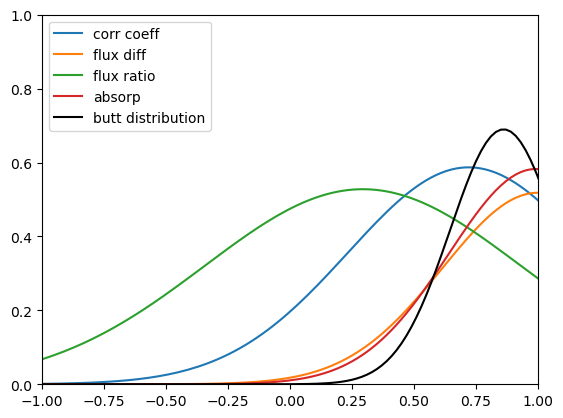

In [37]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, r_17a_dist, label = 'corr coeff' )
ax.plot(x, diff_17a_dist,label = 'flux diff'  )
ax.plot(x, ratio_17a_dist,label = 'flux ratio'  )
ax.plot(x, absorp_17a_dist, label = 'absorp'  )


ax.plot(x, stupid_dpdf, label = 'butt distribution' , c='k' )

ax.set_ylim(0,1)
ax.set_xlim(-1,1)


ax.legend()